# Model SBC Report

In [1]:
import logging
import re
import warnings
from pathlib import Path
from time import time
from typing import Dict, List, Tuple

import arviz as az
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

from src.command_line_interfaces import cli_helpers
from src.loggers import set_console_handler_level
from src.managers.model_cache_managers import Pymc3ModelCacheManager
from src.modeling import pymc3_analysis as pmanal
from src.modeling.simulation_based_calibration_helpers import SBCFileManager
from src.project_enums import ModelFitMethod

In [2]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

set_console_handler_level(logging.WARNING)
pymc3_cache_dir = Path("..", "models", "modeling_cache", "pymc3_model_cache")

Parameters for papermill:

- `MODEL_NAME`: unique, identifiable name of the model
- `SBC_RESULTS_DIR`: directory containing results of many rounds of SBC
- `SBC_COLLATED_RESULTS`: path to collated simulation posteriors
- `NUM_SIMULATIONS`: the number of simiulations; will be used to check that all results are found
- `CONFIG_PATH`: path to the model configuration file
- `FIT_METHOD`: model fitting method used for this SBC

## Setup

### Papermill parameters

In [3]:
MODEL_NAME = ""
SBC_RESULTS_DIR = ""
SBC_COLLATED_RESULTS = ""
NUM_SIMULATIONS = -1
CONFIG_PATH = ""
FIT_METHOD_STR = ""

In [4]:
# Parameters
MODEL_NAME = "sp4-noncentered-copynum"
SBC_RESULTS_DIR = "/n/scratch3/users/j/jc604/speclet-sbc/sp4-noncentered-copynum_MCMC"
SBC_COLLATED_RESULTS = (
    "cache/sbc-cache/sp4-noncentered-copynum_MCMC_collated-posterior-summaries.pkl"
)
NUM_SIMULATIONS = 25
CONFIG_PATH = "models/model-configs.yaml"
FIT_METHOD_STR = "MCMC"

### Prepare and validate papermill parameters

Check values passed as the directory with results of the rounds of SBC.

In [5]:
path_addition = "../.."

sbc_results_dir = Path(path_addition, SBC_RESULTS_DIR)
assert sbc_results_dir.is_dir()
assert sbc_results_dir.exists()

sbc_collated_results_path = Path(path_addition, SBC_COLLATED_RESULTS)
assert sbc_collated_results_path.is_file()
assert sbc_collated_results_path.exists()

Confirm that there is a positive number of simulations.

In [6]:
assert NUM_SIMULATIONS > 0

In [7]:
FIT_METHOD = ModelFitMethod(FIT_METHOD_STR)

## Read in all results

In [8]:
simulation_posteriors_df = pd.read_pickle(sbc_collated_results_path)
simulation_posteriors_df.head()

,,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,true_value,simulation_id,within_hdi
parameter,parameter_name,,,,,,,,,,,,
μ_h,μ_h,-0.047,0.575,-0.908,1.005,0.067,0.086,35.0,109.0,1.82,1.494079,sim_id_0000,False
μ_d,μ_d,0.397,0.557,-0.765,1.109,0.039,0.043,47.0,137.0,1.89,-1.706270,sim_id_0000,False
μ_η,μ_η,-0.000,0.144,-0.210,0.242,0.019,0.019,33.0,152.0,1.12,0.352810,sim_id_0000,False
h_offset[0],h_offset,-0.188,0.220,-0.650,0.090,0.083,0.061,7.0,25.0,1.92,-0.205158,sim_id_0000,True
h_offset[1],h_offset,0.075,0.263,-0.307,0.372,0.109,0.082,6.0,15.0,2.06,0.313068,sim_id_0000,True


## Analysis

### ADVI approximation histories

In [9]:
if FIT_METHOD is ModelFitMethod.ADVI:
    advi_histories: List[np.ndarray] = []

    for dir in sbc_results_dir.iterdir():
        if not dir.is_dir():
            continue

        cache_manager = Pymc3ModelCacheManager(name=MODEL_NAME, root_cache_dir=dir)
        if cache_manager.advi_cache_exists():
            _, advi_approx = cache_manager.get_advi_cache()
            advi_histories.append(advi_approx.hist)
    n_sims_advi_hist = min(NUM_SIMULATIONS, 5)
    sample_hist_idxs = np.random.choice(
        list(range(len(advi_histories))), size=n_sims_advi_hist, replace=False
    )

    def make_hist_df(sim_idx: int, hist_list: List[np.ndarray]) -> pd.DataFrame:
        df = pd.DataFrame({"sim_idx": sim_idx, "loss": hist_list[sim_idx].flatten()})
        df["step"] = np.arange(df.shape[0])
        return df

    sampled_advi_histories = pd.concat(
        [make_hist_df(i, advi_histories) for i in sample_hist_idxs]
    ).reset_index(drop=True)

    (
        gg.ggplot(
            sampled_advi_histories,
            gg.aes(x="step", y="np.log(loss)", color="factor(sim_idx)"),
        )
        + gg.geom_line(alpha=0.5)
        + gg.scale_color_brewer(type="qual", palette="Set1")
        + gg.scale_x_continuous(expand=(0, 0))
        + gg.scale_y_continuous(expand=(0.01, 0, 0.02, 0))
        + gg.theme(legend_position=(0.8, 0.5))
        + gg.labs(y="log loss", color="sim. idx.")
    ).draw()
    plt.show()

### MCMC diagnostics

sbc-perm15
------------------------------
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 336, 303, 151, 281
percent divergences: 0.336, 0.303, 0.151, 0.281
BFMI: 0.416, 0.392, 0.364, 0.39
avg. step size: 0.002, 0.002, 0.002, 0.002


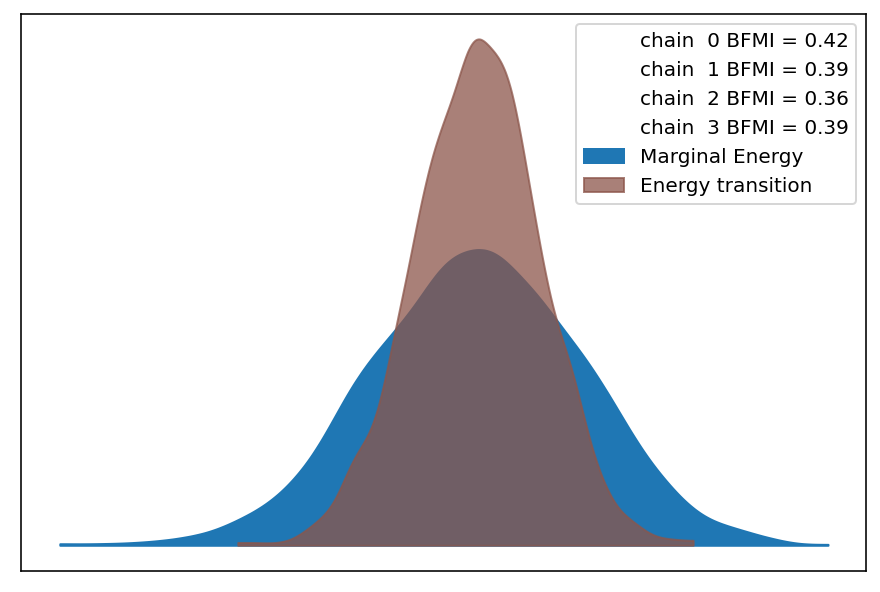

sbc-perm8
------------------------------
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 373, 1000, 1000, 1000
percent divergences: 0.373, 1.0, 1.0, 1.0
BFMI: 0.478, 1.951, 1.909, 1.936
avg. step size: 0.002, 0.002, 0.002, 0.001


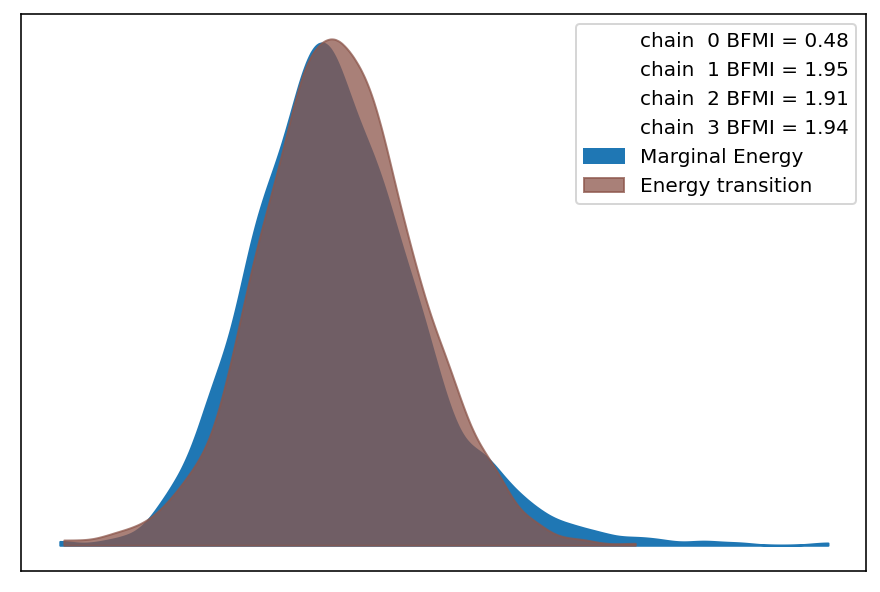

sbc-perm20
------------------------------
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 427, 259, 185, 201
percent divergences: 0.427, 0.259, 0.185, 0.201
BFMI: 0.387, 0.493, 0.326, 0.376
avg. step size: 0.002, 0.002, 0.002, 0.002


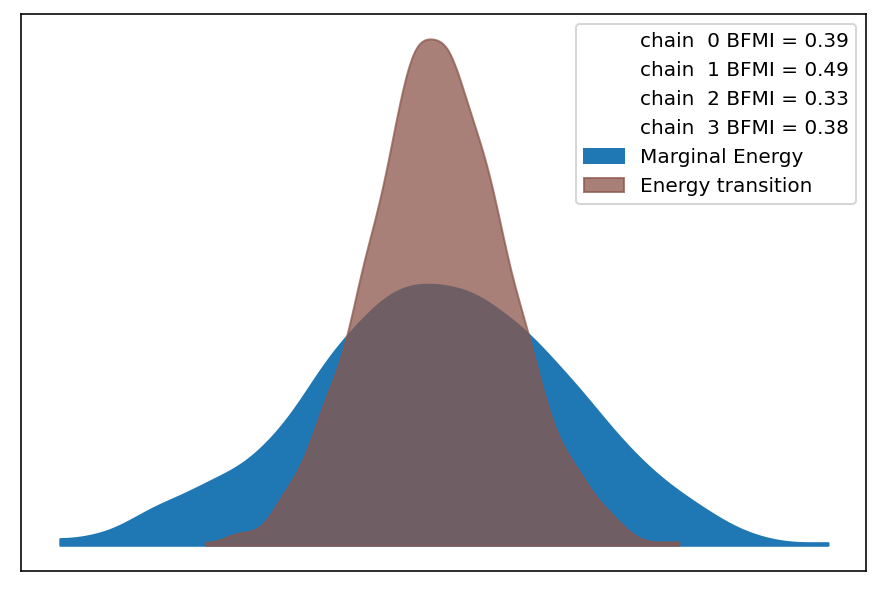

sbc-perm5
------------------------------
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 183, 119, 1000, 1000
percent divergences: 0.183, 0.119, 1.0, 1.0
BFMI: 0.632, 0.452, 1.759, 1.965
avg. step size: 0.001, 0.001, 0.001, 0.001


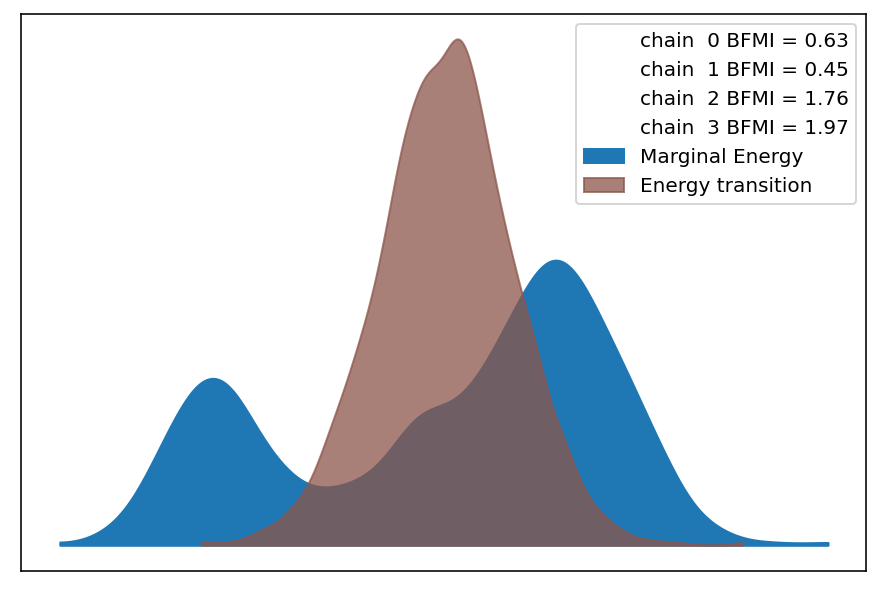

sbc-perm14
------------------------------
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 517, 45, 44, 129
percent divergences: 0.517, 0.045, 0.044, 0.129
BFMI: 0.71, 0.475, 0.328, 0.625
avg. step size: 0.001, 0.001, 0.001, 0.001


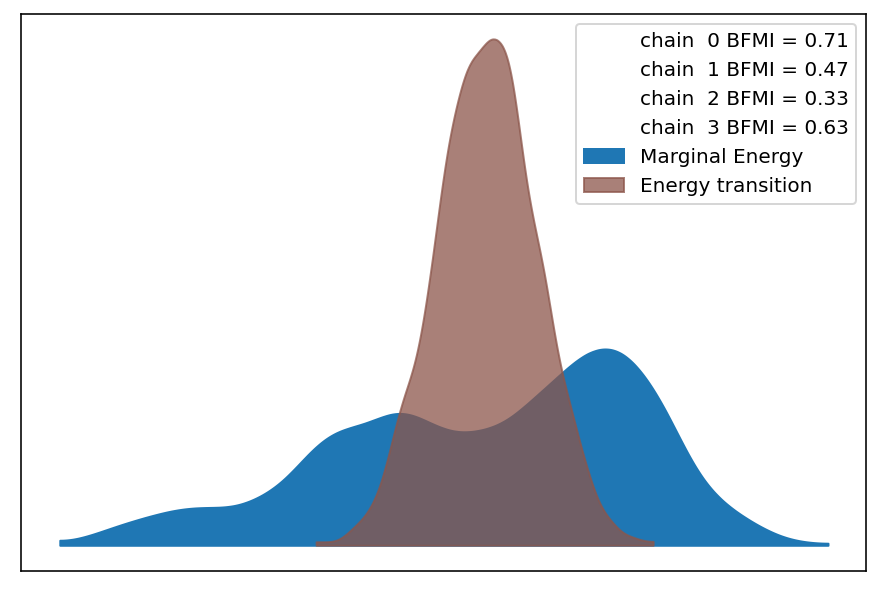

In [10]:
class IncompleteCachedResultsWarning(UserWarning):
    pass


all_sbc_perm_dirs = list(sbc_results_dir.iterdir())

for perm_dir in np.random.choice(
    all_sbc_perm_dirs, size=min([5, len(all_sbc_perm_dirs)]), replace=False
):
    print(perm_dir.name)
    print("-" * 30)
    sbc_fm = SBCFileManager(perm_dir)
    if sbc_fm.all_data_exists():
        sbc_res = sbc_fm.get_sbc_results()
        _ = pmanal.describe_mcmc(sbc_res.inference_obj)
    else:
        warnings.warn(
            "Cannot find all components of the SBC results.",
            IncompleteCachedResultsWarning,
        )

### Estimate accuracy

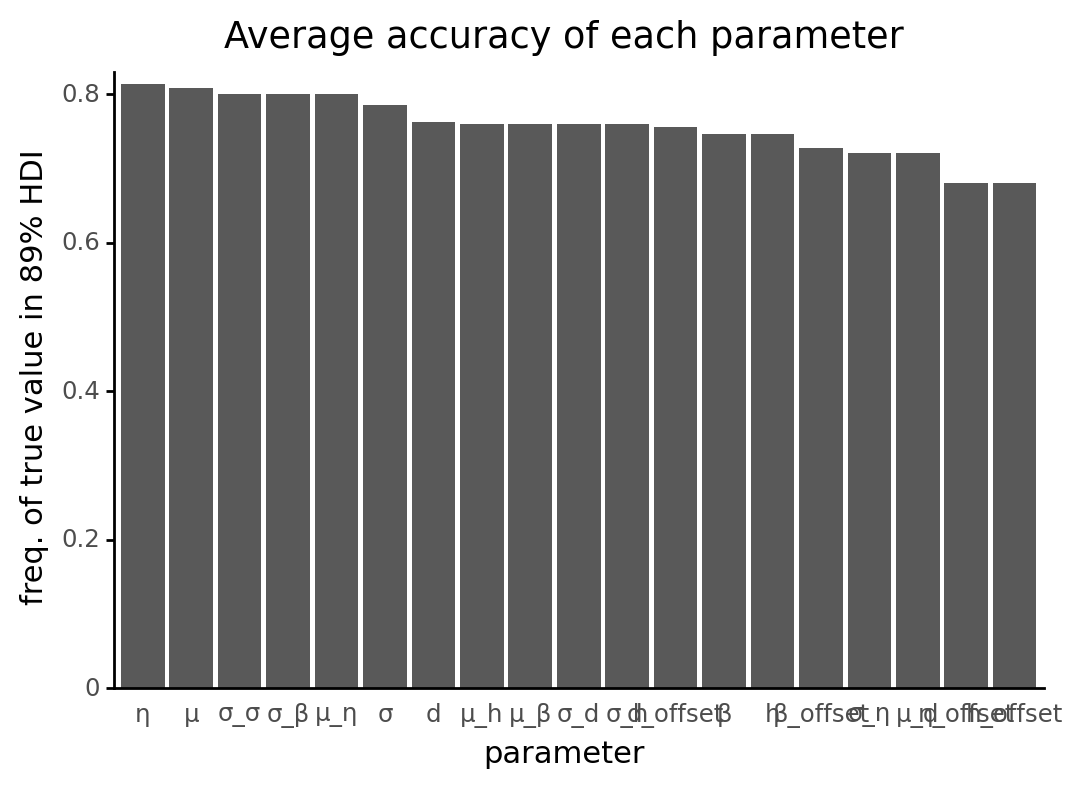

<ggplot: (2946470769716)>

In [11]:
accuracy_per_parameter = (
    simulation_posteriors_df.copy()
    .groupby(["parameter_name"])["within_hdi"]
    .mean()
    .reset_index(drop=False)
    .sort_values("within_hdi", ascending=False)
    .reset_index(drop=True)
)

accuracy_per_parameter["parameter_name"] = pd.Categorical(
    accuracy_per_parameter["parameter_name"],
    categories=accuracy_per_parameter["parameter_name"].values,
)

(
    gg.ggplot(accuracy_per_parameter, gg.aes(x="parameter_name", y="within_hdi"))
    + gg.geom_col()
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(
        x="parameter",
        y="freq. of true value in 89% HDI",
        title="Average accuracy of each parameter",
    )
    + gg.theme(axis_ticks_major_x=gg.element_blank(), figure_size=(6, 4))
)

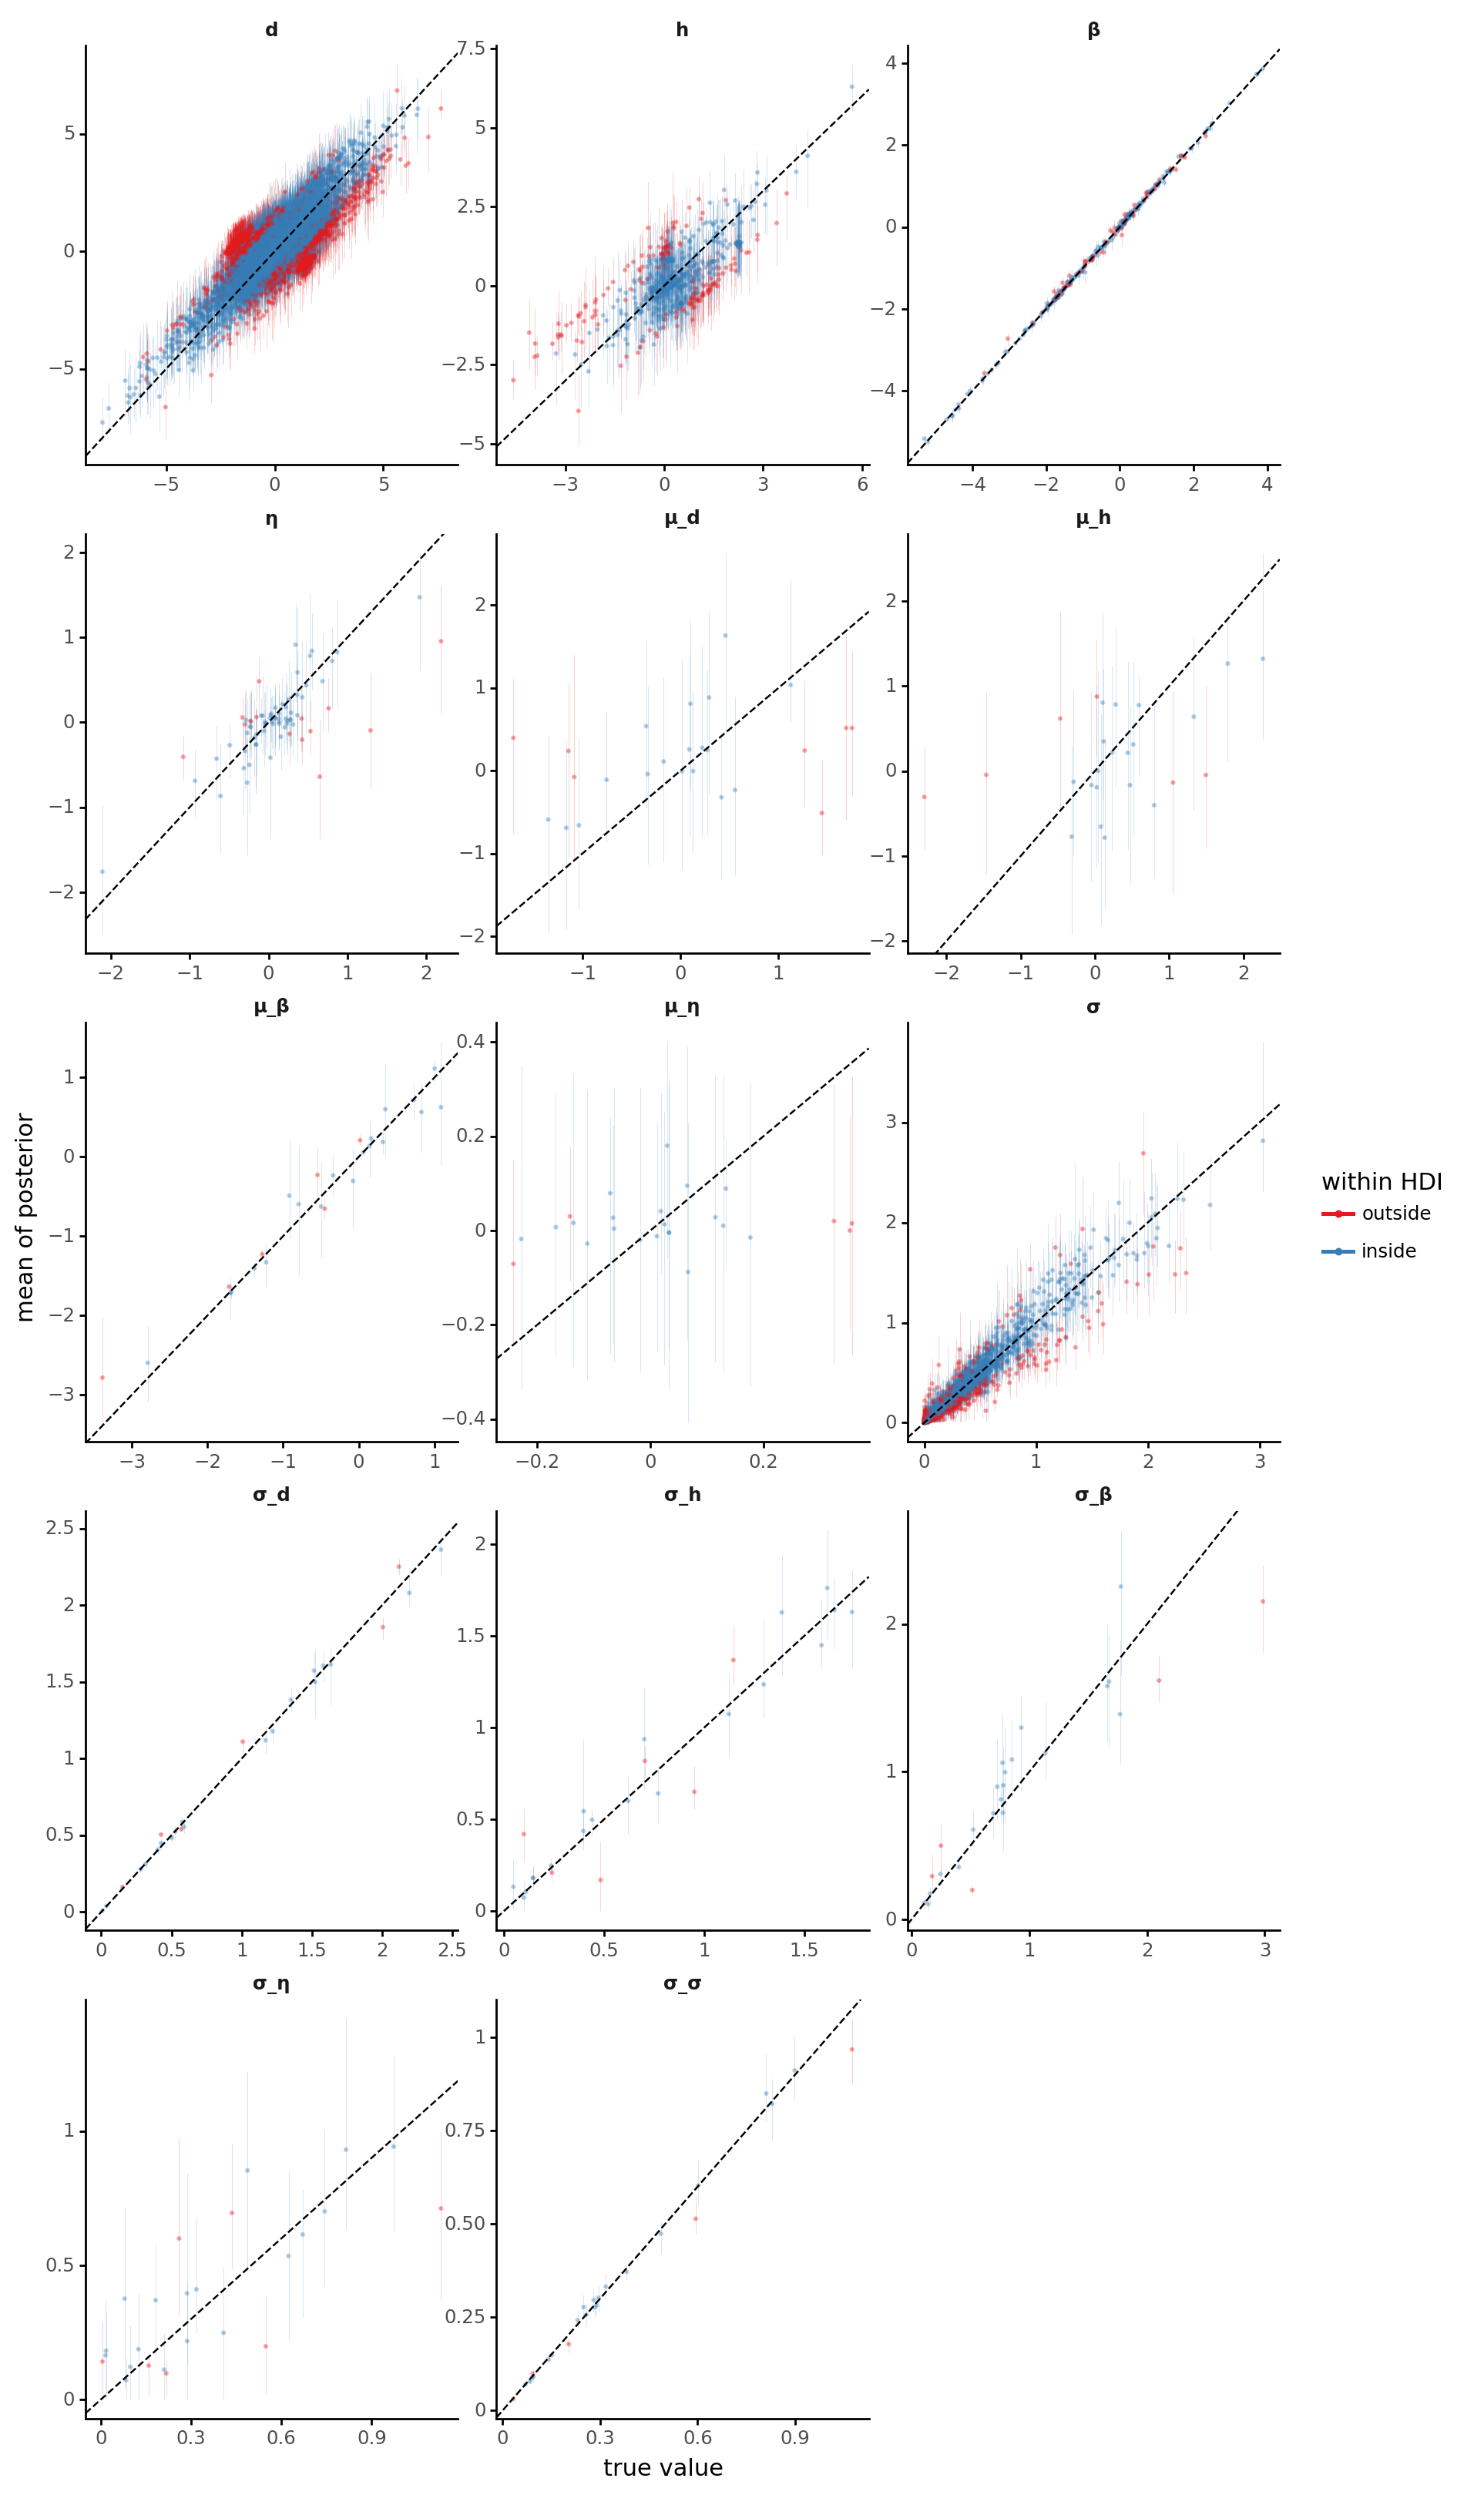

<ggplot: (2946479855601)>

In [12]:
hdi_low, hdi_high = pmanal.get_hdi_colnames_from_az_summary(simulation_posteriors_df)


def filter_uninsteresting_parameters(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.reset_index(drop=False)
        .query("parameter_name != 'μ'")
        .filter_string("parameter_name", search_string="offset", complement=True)
    )


(
    gg.ggplot(
        filter_uninsteresting_parameters(simulation_posteriors_df),
        gg.aes(x="true_value", y="mean", color="within_hdi"),
    )
    + gg.facet_wrap("~ parameter_name", ncol=3, scales="free")
    + gg.geom_linerange(gg.aes(ymin=hdi_low, ymax=hdi_high), alpha=0.2, size=0.2)
    + gg.geom_point(size=0.3, alpha=0.3)
    + gg.geom_abline(slope=1, intercept=0, linetype="--")
    + gg.scale_color_brewer(
        type="qual",
        palette="Set1",
        labels=("outside", "inside"),
        guide=gg.guide_legend(
            title="within HDI",
            override_aes={"alpha": 1, "size": 1},
        ),
    )
    + gg.theme(
        figure_size=(10, 20),
        strip_background=gg.element_blank(),
        strip_text=gg.element_text(face="bold"),
        panel_spacing=0.25,
    )
    + gg.labs(
        x="true value",
        y="mean of posterior",
    )
)

---

In [13]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.50 minutes


In [14]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-07-22

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-81.o2.rc.hms.harvard.edu

Git branch: sp7-parameterizations

numpy     : 1.20.1
re        : 2.2.1
matplotlib: 3.3.4
seaborn   : 0.11.1
logging   : 0.5.1.2
janitor   : 0.20.14
plotnine  : 0.7.1
pandas    : 1.2.3
pymc3     : 3.11.1
arviz     : 0.11.2

